In [1]:
import EDLDE
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

Could not load cython functions. Some functionality might be broken.
Could not load sparse_dot_mkl. Will use scipy.sparse for matrix products.


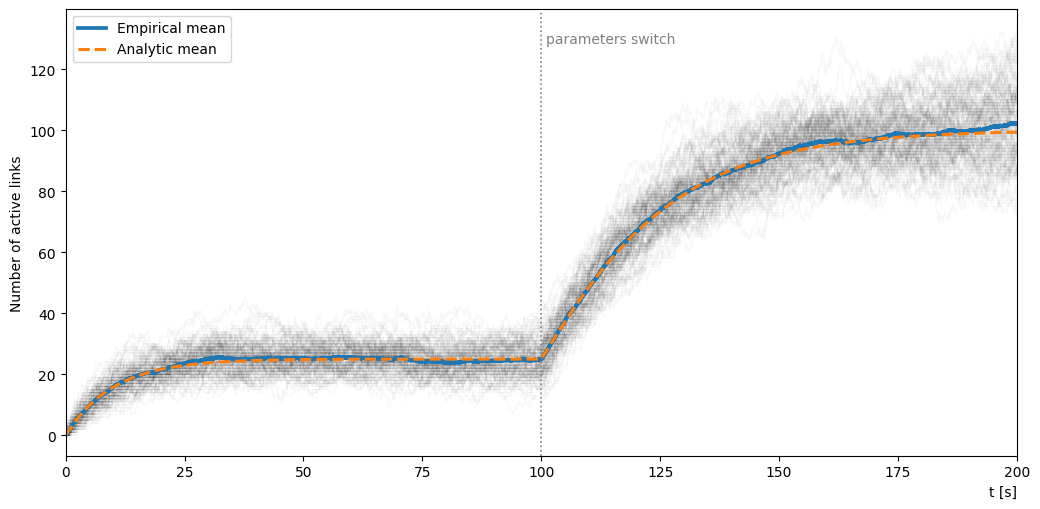

In [4]:
# --- Set your two phases here (make λμ different so stationary levels differ) ---
lam1, mu1 = 2.5, 10.0
lam2, mu2 = 5.0, 20.0

# --- Global time settings ---
t0, t_split, t_end = 0.0, 100.0, 200.0
n_samples = 100
alpha_each, lw_each = 0.03, 0.9

# --- Helpers ---
def step_full_span(change_times, counts_after, t_start, t_end):
    """Build right-continuous step arrays xs, ys with where='post' semantics."""
    if len(change_times) == 0:
        return np.array([t_start, t_end], float), np.array([0.0, 0.0], float)

    # extend plotting horizon if last change is after t_end
    t_plot_end = max(t_end, change_times[-1])

    xs = np.array([t_start] + list(change_times) + [t_plot_end], float)
    ys = np.array([0.0] + list(counts_after) + [counts_after[-1]], float)
    return xs, ys

def m_window_vec(t, lam, mu, a, b):
    """Expected active count from arrivals in [a,b] with rate lam, Exp(mean=mu) lifetimes."""
    t = np.asarray(t)
    out = np.zeros_like(t, dtype=float)
    # a <= t <= b
    mask1 = (t >= a) & (t <= b)
    out[mask1] = lam * mu * (1.0 - np.exp(-(t[mask1] - a) / mu))
    # t > b
    mask2 = t > b
    out[mask2] = lam * mu * (np.exp(-(t[mask2] - b) / mu) - np.exp(-(t[mask2] - a) / mu))
    return out

def m_concat_vec(t):
    """Analytic mean for the two-phase process (sum of two finite-window means)."""
    return (m_window_vec(t, lam1, mu1, t0, t_split) +
            m_window_vec(t, lam2, mu2, t_split, t_end))

# --- Draw samples, plot faint paths, and accumulate deltas for empirical mean ---
fig, ax = plt.subplots(figsize=(10.5, 5.2))
starts_all, ends_all = [], []

t_last_change = t_end

for sample in range(n_samples):
    # Phase 1: [t0, t_split]
    n1, s1, e1 = EDLDE.EDLDE(
        density=lam1, inter_tau=mu1, t_start=t0, t_end=t_split, seed=1415+sample
    )
    # Phase 2: [t_split, t_end]
    n2, s2, e2 = EDLDE.EDLDE(
        density=lam2, inter_tau=mu2, t_start=t_split, t_end=t_end, seed=8281+sample
    )

    # Combine
    starts = np.concatenate([s1, s2])
    ends   = np.concatenate([e1, e2])

    starts_all.append(starts)
    ends_all.append(ends)

    ct, ca = EDLDE.activity_EDLDE(starts, ends)

    # track global last change time (often comes from the last end time)
    if len(ct) > 0:
        t_last_change = max(t_last_change, ct[-1])

    xs, ys = step_full_span(ct, ca, t0, t_end)
    ax.step(xs, ys, where="post", color="k", alpha=alpha_each, linewidth=lw_each)

# --- Empirical mean step via union-of-deltas across samples ---
sum_delta = defaultdict(float)
for s, e in zip(starts_all, ends_all):
    for si in s:
        sum_delta[si] += 1.0
    for ei in e:
        sum_delta[ei] -= 1.0

avg_times, avg_counts, cur = [], [], 0.0
for t in sorted(sum_delta.keys()):
    d = sum_delta[t] / n_samples
    if d != 0.0:
        cur += d
        avg_times.append(t)
        avg_counts.append(cur)

# ensure endpoint is >= last avg_time (avoid backward x)
t_plot_end = max(t_end, (avg_times[-1] if len(avg_times) else t_end), t_last_change)  

if len(avg_times) == 0:
    xs_avg, ys_avg = np.array([t0, t_plot_end]), np.array([0.0, 0.0])  
else:
    xs_avg = np.array([t0] + avg_times + [t_plot_end], float)  
    ys_avg = np.array([0.0] + avg_counts + [avg_counts[-1]], float)

ax.step(xs_avg, ys_avg, where="post", linewidth=2.7, label="Empirical mean")

# --- Analytic mean  ---
t_dense = np.linspace(t0, t_plot_end, 1600)
m_dense = m_concat_vec(t_dense)
ax.plot(t_dense, m_dense, linewidth=2.2, linestyle="--", label="Analytic mean")

# --- Decorations ---
ax.axvline(t_split, color="gray", linestyle=":", linewidth=1.2)
ax.text(t_split+1, ax.get_ylim()[1]*0.92, "parameters switch", fontsize=10, color="gray")

# # also mark where arrivals stop (optional but usually clarifies the tail)
# ax.axvline(t_end, color="gray", linestyle=":", linewidth=1.0)
# ax.text(t_end+1, ax.get_ylim()[1]*0.82, "arrivals stop", fontsize=9, color="gray")

ax.set_xlim(t0, t_end)
ax.set_xlabel("t [s]", loc="right")
ax.set_ylabel("Number of active links")

ax.legend()
plt.tight_layout()
#plt.savefig('/Users/samuelkoovely/Desktop/fig_EDLDE/trajectories_chain.pdf', format='pdf')
plt.show()